In [5]:
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
#from sklearn.model_selection import train_test_split 
#from sklearn.linear_model import LinearRegression
#from sklearn import metrics
from numpy.polynomial.polynomial import polyfit
#from sklearn.metrics import r2_score

# host + port
host = 'http://localhost:7474'

# select database name
db_name = 'modelparallel'

# credentials for API
user = 'neo4j'
passwd = '1234'

model_graph = Graph(host, auth=(user, passwd), name=db_name)

#path of file linux
#path_file = '/home/philipp/Desktop/masterarbeit/thesis/thesis_files/abbildungen/'

#path of file windows
path_file = "C:\\Users\\philipp\\Desktop\\HS\\masterarbeit\\thesis\\thesis_files\\abbildungen\\"

#specific = ''
#plt.savefig(path_file + specific + '.png', bbox_inches='tight')


In [34]:
model_graph.run("""
    MATCH (m1:Molecule)-[c:POTENTIAL_TRANSFORMATION]->(m2:Molecule)
    WITH m1, count(c) as rel_out
    MATCH (m1)
    WHERE rel_out < 10
    DETACH DELETE (m1) 
    RETURN count(m1)
""")

count(m1)
0


In [23]:
# Existenz eingehender und ausgehender Kanten prüfen 

model_graph.run("""
    MATCH (m:Molecule)-[:MEASURED_IN]->(t:Measurement)
    WHERE NOT EXISTS((m)-[:SAME_AS]-(:Molecule)) AND t.point_in_time < 13
    RETURN count(m)
""")

count(m)
9746


      formula_string   mid  rel_out
0         C12 H10 O8  7839       15
1      C14 H23 N1 O4  7863       14
2         C10 H18 O4  7839       14
3         C15 H24 O4  7868       14
4        C22 H36 O10  7857       14
...              ...   ...      ...
30221    C26 H26 O13  7868        1
30222    C26 H26 O12  7868        1
30223    C28 H30 O17  7845        1
30224  C28 H30 O5 S1  7845        1
30225     C26 H30 O6  7803        1

[30226 rows x 3 columns]
         formula_string   mid  rel_out
0         C14 H18 O7 S1  7863       19
1         C15 H20 O7 S1  7815       18
2         C15 H20 O7 S1  7863       18
3         C15 H20 O7 S1  7868       18
4         C15 H20 O8 S1  7857       18
...                 ...   ...      ...
96117     C22 H21 N3 O9  7868        1
96118    C22 H21 N3 O10  7845        1
96119     C22 H24 N4 O6  7857        1
96120    C23 H23 N3 O11  7839        1
96121  C22 H23 N5 O5 S3  7845        1

[96122 rows x 3 columns]
    rel_out  formula_string   hti_perc
0        

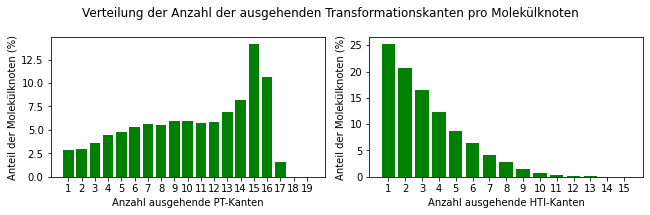

In [11]:
# ausgehende HTI Kanten pro Moleküle

most_outgoing_relationships = model_graph.run("""
    MATCH (m:Molecule)-[c:HAS_TRANSFORMED_INTO]->(:Molecule)
    RETURN m.formula_string as formula_string, m.sample_id as mid, count(c) as rel_out
    //RETURN m.formula_string as formula_string, count(c) as rel_out
    ORDER BY count(c) DESC
""").to_data_frame()

MATCH (m1:Molecule)-[c:POTENTIAL_TRANSFORMATION]->(m2:Molecule)
WITH m1, count(c) as rel_out
MATCH (m1)
WHERE rel_out < 10
DETACH DELETE (m1)  

mor_cti = model_graph.run("""
    MATCH (m:Molecule)-[c:POTENTIAL_TRANSFORMATION]->(:Molecule)
    RETURN m.formula_string as formula_string, m.sample_id as mid, count(c) as rel_out
    //RETURN m.formula_string as formula_string, count(c) as rel_out
    ORDER BY count(c) DESC
""").to_data_frame()

print(most_outgoing_relationships)
print(mor_cti)

#print(most_outgoing_relationships)

af = {'formula_string':'count'}
mor = most_outgoing_relationships.groupby(most_outgoing_relationships['rel_out'], as_index=False).aggregate(af)
mor['hti_perc'] = mor.formula_string/mor.formula_string.sum()*100
print(mor)
print(mor.formula_string.sum())
print(mor.formula_string.mean())

af_cti = {'formula_string':'count'}
mor_cti = mor_cti.groupby(mor_cti['rel_out'], as_index=False).aggregate(af_cti)
mor_cti['cti_perc'] = mor_cti.formula_string/mor_cti.formula_string.sum()*100
print(mor_cti)
print(mor_cti.formula_string.sum())
print(mor_cti.formula_string.mean())
print(mor_cti.cti_perc.sum())
print(mor.hti_perc.sum())

y = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.suptitle('Verteilung der Anzahl der ausgehenden Transformationskanten pro Molekülknoten')
plt.bar(mor_cti.rel_out, mor_cti.cti_perc, color='green')
plt.xlabel('Anzahl ausgehende PT-Kanten')
plt.ylabel('Anteil der Molekülknoten (%)')
plt.xticks(y)

plt.subplot(1, 2, 2)
plt.bar(mor.rel_out, mor.hti_perc, color='green')
plt.xlabel('Anzahl ausgehende HTI-Kanten')
plt.ylabel('Anteil der Molekülknoten (%)')
plt.xticks(x)

plt.tight_layout()

specific = 'abb_074_ausgehende_hti_cti'
plt.savefig(path_file + specific + '.pdf', bbox_inches='tight')

plt.show()

2521.5
3243.5
897.4166666666666
6662.416666666667
8513.76923076923


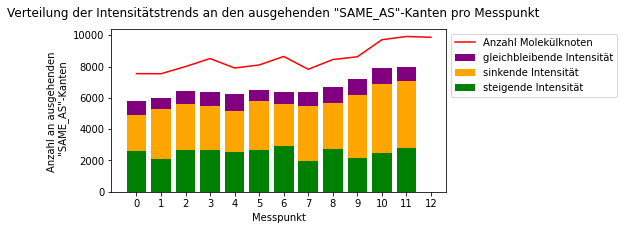

In [2]:
# Verteilung der Intensitätstrends je Messpunkt

inc_rel = model_graph.run("""
    MATCH (t:Measurement)-[:MEASURED_IN]-(m:Molecule)-[s:SAME_AS]->(m2:Molecule)
    WHERE s.intensity_trend >= 1.025
    RETURN t.point_in_time as time, count(s) as increase
""").to_data_frame()

dec_rel = model_graph.run("""
    MATCH (t:Measurement)-[:MEASURED_IN]-(m:Molecule)-[s:SAME_AS]->(m2:Molecule)
    WHERE s.intensity_trend <= 0.975
    RETURN t.point_in_time as time, count(s) as decrease
""").to_data_frame()

same_rel = model_graph.run("""
    MATCH (t:Measurement)-[:MEASURED_IN]-(m:Molecule)-[s:SAME_AS]->(m2:Molecule)
    WHERE 0.975 < s.intensity_trend < 1.025
    RETURN t.point_in_time as time, count(s) as same
""").to_data_frame()

get_mol = model_graph.run("""
    MATCH (m:Molecule)-[]-(t:Measurement)
    WHERE t.point_in_time < 13
    RETURN t.point_in_time as time, count(m) as cmol
""").to_data_frame()

print(inc_rel.increase.mean())
print(dec_rel.decrease.mean())
print(same_rel.same.mean())
inc_rel['mid'] = inc_rel.increase + dec_rel.decrease + same_rel.same
print(inc_rel.mid.mean())
print(get_mol.cmol.mean())

plt.figure(figsize=(6, 3))
plt.suptitle('Verteilung der Intensitätstrends an den ausgehenden "SAME_AS"-Kanten pro Messpunkt')
#plt.bar(outgoing_relationships.time, outgoing_relationships.relationships_out)
plt.bar(same_rel.time, inc_rel.increase + dec_rel.decrease + same_rel.same, color = 'purple')
plt.bar(dec_rel.time, dec_rel.decrease + inc_rel.increase, color = 'orange')
plt.bar(inc_rel.time, inc_rel.increase, color = 'green')
plt.plot(get_mol.time, get_mol.cmol, color = 'red')
plt.xlabel('Messpunkt')
plt.ylabel('Anzahl an ausgehenden \n "SAME_AS"-Kanten')
plt.legend(['Anzahl Molekülknoten', 'gleichbleibende Intensität', 'sinkende Intensität', 'steigende Intensität'], loc='upper left', bbox_to_anchor=(1, 1))
x = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.xticks(x)

specific = '000_a'
plt.savefig(path_file + specific + '.png', bbox_inches='tight')

plt.show()

    time  relationships_out
0      0              71129
1      1              73815
2      2              79063
3      3              79858
4      4              77633
5      5              80914
6      6              80144
7      7              78976
8      8              84264
9      9              90570
10    10              99168
11    11             100673
gesamt: 996207
std: 9248.098449509402
arithmetisches Mittel:  83017.25
diff:  83017.25
    time  relationships_out
0      0               8400
1      1               7215
2      2               8189
3      3               8469
4      4               8641
5      5               7016
6      6               7888
7      7               8207
8      8               9239
9      9               9280
10    10               8329
11    11               8899
gesamt: 99772
std: 698.7478844766588
arithmetisches Mittel:  8314.333333333334
[1.0377623754024379, 1.0710966605703447, 1.010055272377724, 0.9721380450299282, 1.042262955186583, 0.99048

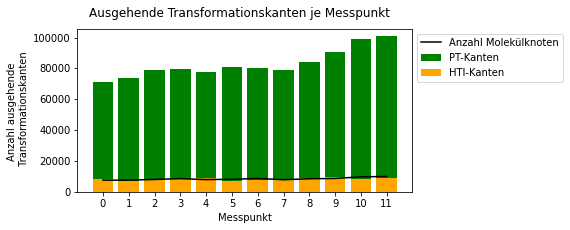

In [3]:
# Anzahl der ausgehenden Transformationskanten je Messpunkt

or_cti = model_graph.run("""
    MATCH (t1:Measurement)-[:MEASURED_IN]-(:Molecule)-[c:POTENTIAL_TRANSFORMATION]->(:Molecule)-[:MEASURED_IN]-(t2:Measurement)
    WHERE t2.point_in_time = t1.point_in_time + 1
    RETURN t1.point_in_time as time, count(c) as relationships_out
""").to_data_frame()

or_hti = model_graph.run("""
    MATCH (t1:Measurement)-[:MEASURED_IN]-(:Molecule)-[c:HAS_TRANSFORMED_INTO]->(:Molecule)-[:MEASURED_IN]-(t2:Measurement)
    WHERE t2.point_in_time = t1.point_in_time + 1
    RETURN t1.point_in_time as time, count(c) as relationships_out
""").to_data_frame()

get_mol = model_graph.run("""
    MATCH (m:Molecule)-[]-(t:Measurement)
    WHERE t.point_in_time < 12
    RETURN t.point_in_time as time, count(m) as cmol
""").to_data_frame()

print(or_cti)
print("gesamt:", or_cti["relationships_out"].sum())
print("std:", or_cti["relationships_out"].std())
print("arithmetisches Mittel: ", or_cti["relationships_out"].mean())
print("diff: ", or_cti["relationships_out"].mean())

print(or_hti)
print("gesamt:", or_hti["relationships_out"].sum())
print("std:", or_hti["relationships_out"].std())
print("arithmetisches Mittel: ", or_hti["relationships_out"].mean())

def calc_tendency(df):
    help_list = []
    for i in range(1,12):
        erg = df.relationships_out[i]/df.relationships_out[i-1]
        help_list.append(erg)
    tendency = (sum(help_list)/len(help_list)-1)*100
    print(help_list)
    print(sum(help_list))
    print(len(help_list))
    return tendency

def calc_tendency_test(df):
    help_list = []
    for i in range(1,12):
        erg = df.relationships_out[i]/df.relationships_out[0]
        help_list.append(erg)
    tendency = (sum(help_list)/len(help_list)-1)*100
    print(help_list)
    print(sum(help_list))
    print(len(help_list))
    return tendency
        
print(calc_tendency(or_cti))
#print(calc_tendency(or_hti))
    
print(calc_tendency_test(or_cti))
#print(calc_tendency_test(or_hti))

plt.figure(figsize=(6, 3))

plt.suptitle('Ausgehende Transformationskanten je Messpunkt')
plt.xlabel('Messpunkt')
plt.ylabel('Anzahl ausgehende \n Transformationskanten')
plt.bar(or_cti.time, or_cti.relationships_out, color='green')
plt.bar(or_hti.time, or_hti.relationships_out, color='orange')
plt.plot(get_mol.time, get_mol.cmol, color = 'black', lw=1.5)
plt.legend(['Anzahl Molekülknoten', 'PT-Kanten', 'HTI-Kanten'], loc='upper left', bbox_to_anchor=(1, 1))
x = [0,1,2,3,4,5,6,7,8,9,10,11]
plt.xticks(x)

specific = '000_b'
plt.savefig(path_file + specific + '.png', bbox_inches='tight')

plt.show()

   funktionelle_Gruppe  Anzahl_HTI_Kanten  Anzahl_CTI_Kanten  share_hti  \
0              -C1 -O1               7040              68405   7.056088   
1                  -C1               6978              68870   6.993946   
2              -C1 -H2               6941              71479   6.956862   
3                   O1               6656              67671   6.671210   
4                  -H2               6551              67770   6.565970   
5              -C2 -H2               6550              64652   6.564968   
6                H2 O1               6457              61039   6.471756   
7           -C1 -H2 O1               6198              62519   6.212164   
8               -H2 O1               6183              64851   6.197129   
9          -C2 -H4 -O1               6166              64370   6.180091   
10             -C1 -O2               6097              58343   6.110933   
11         -C4 -H4 -O1               5757              55701   5.770156   
12                  O2   

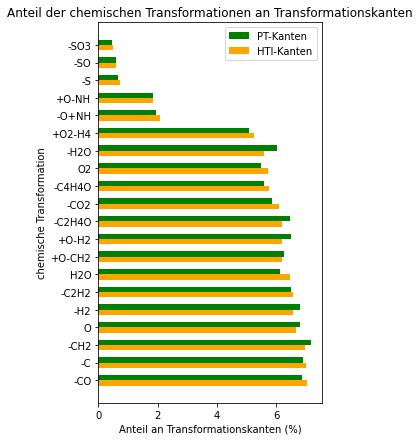

In [4]:
# Welche Transformationen kommen am Häufigsten vor

transform_count_hti = model_graph.run("""
MATCH ()-[t:HAS_TRANSFORMED_INTO]->()
RETURN t.transformation_unit as funktionelle_Gruppe, count(t.transformation_unit) as Anzahl_HTI_Kanten
ORDER BY Anzahl_HTI_Kanten DESC
""").to_data_frame()

transform_count_cti = model_graph.run("""
MATCH ()-[t:POTENTIAL_TRANSFORMATION]->()
RETURN t.tu_pt as funktionelle_Gruppe, count(t.tu_pt) as Anzahl_CTI_Kanten
ORDER BY Anzahl_CTI_Kanten DESC
""").to_data_frame()

#print(transform_count_hti)
#print("gesamt:", transform_count_hti.Anzahl_HTI_Kanten.sum())

#print(transform_count_cti)
#print("gesamt:", transform_count_cti.Anzahl_CTI_Kanten.sum())

df_join = pd.merge(transform_count_hti, transform_count_cti, on=["funktionelle_Gruppe"])
df_join['share_hti'] = df_join.Anzahl_HTI_Kanten/df_join.Anzahl_HTI_Kanten.sum()*100
df_join['share_cti'] = df_join.Anzahl_CTI_Kanten/df_join.Anzahl_CTI_Kanten.sum()*100
df_join['fg'] = ['-CO', '-C', '-CH2', 'O', '-H2', '-C2H2', 'H2O', '+O-CH2', '+O-H2', '-C2H4O', '-CO2', '-C4H4O', 'O2', '-H2O', '+O2-H4', '-O+NH', '+O-NH', '-S', '-SO', '-SO3']

#new_row_0 = {'funktionelle_Gruppe':'NO2', 'Anzahl_HTI_Kanten':0, 'Anzahl_CTI_Kanten':0, 'share_hti':0 , 'share_cti':0 , 'fg':'NO2'}
#new_row_1 = {'funktionelle_Gruppe':'-NO2', 'Anzahl_HTI_Kanten':0, 'Anzahl_CTI_Kanten':0, 'share_hti':0 , 'share_cti':0 , 'fg':'-NO2'}
#df_join = df_join.append(new_row_0, ignore_index=True)
#df_join = df_join.append(new_row_1, ignore_index=True)

df_join['diff'] = df_join.share_hti/df_join.share_cti
print(df_join)


labels = ['-CO', '-C', '-CH2', 'O', '-H2', '-C2H2', 'H2O', '+O-CH2', '+O-H2', '-C2H4O', '-CO2', '-C4H4O', 'O2', '-H2O', '+O2-H4', '-O+NH', '+O-NH', '-S', '-SO', '-SO3']
x = np.arange(len(labels))
height = 0.3
plt.figure(figsize=(4, 7))
plt.barh(x + height/2, df_join.share_cti, height = 0.3, color='green')
plt.barh(x - height/2 , df_join.share_hti, height = 0.3, color='orange')
plt.yticks(x, labels = labels)
plt.title('Anteil der chemischen Transformationen an Transformationskanten')
plt.ylabel('chemische Transformation')
plt.xlabel('Anteil an Transformationskanten (%)')
plt.legend(['PT-Kanten', 'HTI-Kanten'])

specific = '000_c'
plt.savefig(path_file + specific + '.png', bbox_inches='tight')

plt.show()

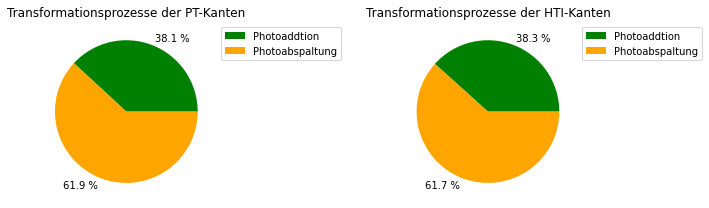

In [16]:
# Photoaddition und Photoabspaltung Zahlenvergleich

get_trans = model_graph.run("""
    MATCH (:Molecule)-[t:POTENTIAL_TRANSFORMATION]->(:Molecule)
    WHERE t.tu_pt IN ['-C1 -H2 O1', '-H2 O1', '-H1 O1 -N1', 'O1', 'H2 O1', '-H4 O2', 'O2', 'O2 N1']
    RETURN count(t)
""").to_data_frame()

trans_cti = [379954, 616253]
trans_hti = [38256,61516]


plt.figure(figsize=(11, 3))
plt.subplot(1, 2, 1)
plt.title('Transformationsprozesse der PT-Kanten')
plt.pie(trans_cti, labels = ['38.1 %', '61.9 %'], colors = ['green', 'orange'])
plt.legend(['Photoaddtion', 'Photoabspaltung'], loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(1, 2, 2)
plt.title('Transformationsprozesse der HTI-Kanten')
plt.pie(trans_hti, labels = ['38.3 %', '61.7 %'], colors = ['green', 'orange'])
plt.legend(['Photoaddtion', 'Photoabspaltung'], loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

#specific = 'abb_073_verteilung_trans'
#plt.savefig(path_file + specific + '.pdf', bbox_inches='tight')

plt.show()

    index  time       fg  HTI_Kanten
0      16     0  -O3 -S1          29
1      39     1  -O3 -S1          63
2      59     2  -O3 -S1          36
3      77     3  -O3 -S1          46
4      96     4  -O3 -S1          27
5     119     5  -O3 -S1           7
6     138     6  -O3 -S1          60
7     157     7  -O3 -S1          35
8     179     8  -O3 -S1          27
9     199     9  -O3 -S1          27
10    208    10  -O3 -S1          69
11    230    11  -O3 -S1          65
[3.5878718203019577, 3.0348247955552132, 3.2478702110715796, 3.254462594080132, 3.1252912273491695, 3.403978358540116, 3.1543745674638135, 3.053592899487767, 3.1159208883067, 5.039981343869826, 3.053945970471039, 3.306364347338886, 3.3652034897496463, 3.0255488197374225, 3.2952361759937654, 3.110990420499271, 5.4057722789008, 4.96223174770789, 4.619257033854773, 5.246807702626244]
[3.5560173488340174, 1.061328668999395, 1.3503535733360605, 1.3204172945754822, 0.977710482102423, 2.460366800246283, 5.950190465468785

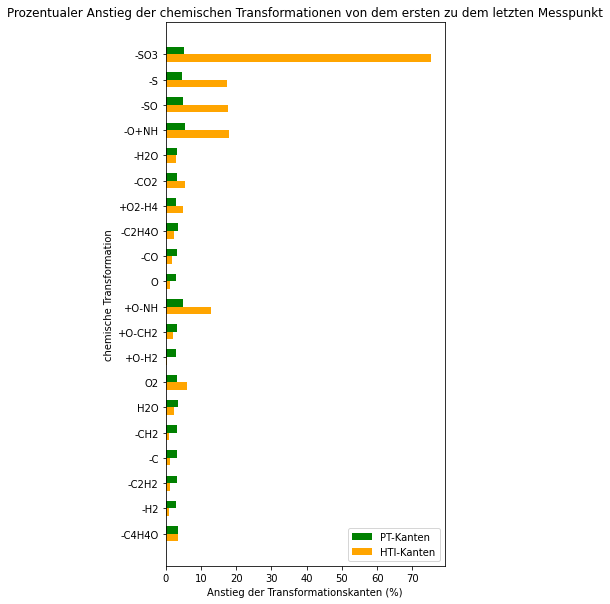

In [17]:
tc_cti = model_graph.run("""
MATCH (m:Measurement)<-[:MEASURED_IN]-(:Molecule)-[t:POTENTIAL_TRANSFORMATION]->(:Molecule)
RETURN m.point_in_time as time , t.tu_pt as fg, count(t.tu_pt) as CTI_Kanten
ORDER BY time
""").to_data_frame()

cti_0 = tc_cti[tc_cti['fg'] == '-C4 -H4 -O1'].reset_index()
cti_1 = tc_cti[tc_cti['fg'] == '-H2'].reset_index()
cti_2 = tc_cti[tc_cti['fg'] == '-C2 -H2'].reset_index()
cti_3 = tc_cti[tc_cti['fg'] == '-C1'].reset_index()
cti_4 = tc_cti[tc_cti['fg'] == '-C1 -H2'].reset_index()
cti_5 = tc_cti[tc_cti['fg'] == 'H2 O1'].reset_index()
cti_6 = tc_cti[tc_cti['fg'] == 'O2'].reset_index()
cti_7 = tc_cti[tc_cti['fg'] == '-H2 O1'].reset_index()
cti_8 = tc_cti[tc_cti['fg'] == '-C1 -H2 O1'].reset_index()
cti_9 = tc_cti[tc_cti['fg'] == '-H1 O1 -N1'].reset_index()
cti_10 = tc_cti[tc_cti['fg'] == 'O1'].reset_index()
cti_11 = tc_cti[tc_cti['fg'] == '-C1 -O1'].reset_index()
cti_12 = tc_cti[tc_cti['fg'] == '-C2 -H4 -O1'].reset_index()
cti_13 = tc_cti[tc_cti['fg'] == '-H4 O2'].reset_index()
cti_14 = tc_cti[tc_cti['fg'] == '-C1 -O2'].reset_index()
cti_15 = tc_cti[tc_cti['fg'] == '-H2 -O1'].reset_index()
cti_16 = tc_cti[tc_cti['fg'] == 'H1 -O1 N1'].reset_index()
cti_17 = tc_cti[tc_cti['fg'] == '-O1 -S1'].reset_index()
cti_18 = tc_cti[tc_cti['fg'] == '-S1'].reset_index()
cti_19 = tc_cti[tc_cti['fg'] == '-O3 -S1'].reset_index()

tc_hti = model_graph.run("""
MATCH (m:Measurement)<-[:MEASURED_IN]-(:Molecule)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
RETURN m.point_in_time as time , t.transformation_unit as fg, count(t.transformation_unit) as HTI_Kanten
ORDER BY time
""").to_data_frame()

hti_0 = tc_hti[tc_hti['fg'] == '-C4 -H4 -O1'].reset_index()
hti_1 = tc_hti[tc_hti['fg'] == '-H2'].reset_index()
hti_2 = tc_hti[tc_hti['fg'] == '-C2 -H2'].reset_index()
hti_3 = tc_hti[tc_hti['fg'] == '-C1'].reset_index()
hti_4 = tc_hti[tc_hti['fg'] == '-C1 -H2'].reset_index()
hti_5 = tc_hti[tc_hti['fg'] == 'H2 O1'].reset_index()
hti_6 = tc_hti[tc_hti['fg'] == 'O2'].reset_index()
hti_7 = tc_hti[tc_hti['fg'] == '-H2 O1'].reset_index()
hti_8 = tc_hti[tc_hti['fg'] == '-C1 -H2 O1'].reset_index()
hti_9 = tc_hti[tc_hti['fg'] == '-H1 O1 -N1'].reset_index()
hti_10 = tc_hti[tc_hti['fg'] == 'O1'].reset_index()
hti_11 = tc_hti[tc_hti['fg'] == '-C1 -O1'].reset_index()
hti_12 = tc_hti[tc_hti['fg'] == '-C2 -H4 -O1'].reset_index()
hti_13 = tc_hti[tc_hti['fg'] == '-H4 O2'].reset_index()
hti_14 = tc_hti[tc_hti['fg'] == '-C1 -O2'].reset_index()
hti_15 = tc_hti[tc_hti['fg'] == '-H2 -O1'].reset_index()
hti_16 = tc_hti[tc_hti['fg'] == 'H1 -O1 N1'].reset_index()
hti_17 = tc_hti[tc_hti['fg'] == '-O1 -S1'].reset_index()
hti_18 = tc_hti[tc_hti['fg'] == '-S1'].reset_index()
hti_19 = tc_hti[tc_hti['fg'] == '-O3 -S1'].reset_index()


def calc_trend_cti(df):
    help_list = []
    for i in range(1,12):
        erg = df.CTI_Kanten[i]/df.CTI_Kanten[i-1]
        help_list.append(erg)
    tendency = (sum(help_list)/len(help_list)-1)*100
    #print(sum(help_list))
    return tendency

def calc_trend_hti(df):
    help_list = []
    for i in range(1,12):
        erg = df.HTI_Kanten[i]/df.HTI_Kanten[i-1]
        help_list.append(erg)
    tendency = (sum(help_list)/len(help_list)-1)*100
    #print(sum(help_list))
    return tendency
        
chti_0 = calc_trend_hti(hti_0)
chti_1 = calc_trend_hti(hti_1)
chti_2 = calc_trend_hti(hti_2)
chti_3 = calc_trend_hti(hti_3)
chti_4 = calc_trend_hti(hti_4)
chti_5 = calc_trend_hti(hti_5)
chti_6 = calc_trend_hti(hti_6)
chti_7 = calc_trend_hti(hti_7)
chti_8 = calc_trend_hti(hti_8)
chti_9 = calc_trend_hti(hti_9)
chti_10 = calc_trend_hti(hti_10)
chti_11 = calc_trend_hti(hti_11)
chti_12 = calc_trend_hti(hti_12)
chti_13 = calc_trend_hti(hti_13)
chti_14 = calc_trend_hti(hti_14)
chti_15 = calc_trend_hti(hti_15)
chti_16 = calc_trend_hti(hti_16)
chti_17 = calc_trend_hti(hti_17)
chti_18 = calc_trend_hti(hti_18)
chti_19 = calc_trend_hti(hti_19)

ccti_0 = calc_trend_cti(cti_0)
ccti_1 = calc_trend_cti(cti_1)
ccti_2 = calc_trend_cti(cti_2)
ccti_3 = calc_trend_cti(cti_3)
ccti_4 = calc_trend_cti(cti_4)
ccti_5 = calc_trend_cti(cti_5)
ccti_6 = calc_trend_cti(cti_6)
ccti_7 = calc_trend_cti(cti_7)
ccti_8 = calc_trend_cti(cti_8)
ccti_9 = calc_trend_cti(cti_9)
ccti_10 = calc_trend_cti(cti_10)
ccti_11 = calc_trend_cti(cti_11)
ccti_12 = calc_trend_cti(cti_12)
ccti_13 = calc_trend_cti(cti_13)
ccti_14 = calc_trend_cti(cti_14)
ccti_15 = calc_trend_cti(cti_15)
ccti_16 = calc_trend_cti(cti_16)
ccti_17 = calc_trend_cti(cti_17)
ccti_18 = calc_trend_cti(cti_18)
ccti_19 = calc_trend_cti(cti_19)

cti_list = [ccti_0, ccti_1, ccti_2, ccti_3, ccti_4, ccti_5, ccti_6, ccti_7, ccti_8, ccti_9, ccti_10, ccti_11, ccti_12, ccti_13, ccti_14, ccti_15, ccti_16, ccti_17, ccti_18, ccti_19]
hti_list = [chti_0, chti_1, chti_2, chti_3, chti_4, chti_5, chti_6, chti_7, chti_8, chti_9, chti_10, chti_11, chti_12, chti_13, chti_14, chti_15, chti_16, chti_17, chti_18, chti_19]
print(hti_19)
print(cti_list)
print(hti_list)

labels = ['-C4H4O', '-H2', '-C2H2', '-C', '-CH2', 'H2O', 'O2', '+O-H2', '+O-CH2', '+O-NH', 'O', '-CO', '-C2H4O', '+O2-H4', '-CO2', '-H2O', '-O+NH', '-SO', '-S', '-SO3']
x = np.arange(len(labels))
height = 0.3
plt.figure(figsize=(5, 10))
plt.barh(x + height/2, cti_list, height = 0.3, color='green', label='CTI-Kanten')
plt.barh(x - height/2 , hti_list, height = 0.3, color='orange', label='HTI-Kanten')
plt.yticks(x, labels = labels)
plt.title('Prozentualer Anstieg der chemischen Transformationen von dem ersten zu dem letzten Messpunkt')
plt.ylabel('chemische Transformation')
plt.xlabel('Anstieg der Transformationskanten (%)')
plt.legend(['PT-Kanten', 'HTI-Kanten'])

specific = 'abb_079_anstieg_trans'
plt.savefig(path_file + specific + '.pdf', bbox_inches='tight')

plt.show()

   funktionelle_Gruppe  Anzahl_HTI_Kanten  avg_combined  avg_connect
0              -C1 -O1           7.056088      0.271610    26.623324
1                  -C1           6.993946      0.242761    23.646274
2              -C1 -H2           6.956862      0.242937    23.567065
3                   O1           6.671210      0.237454    23.658098
4                  -H2           6.565970      0.254149    25.391131
5              -C2 -H2           6.564968      0.242005    23.532870
6                H2 O1           6.471756      0.251595    25.347313
7           -C1 -H2 O1           6.212164      0.228543    22.715682
8               -H2 O1           6.197129      0.234978    23.773896
9          -C2 -H4 -O1           6.180091      0.250388    24.329517
10             -C1 -O2           6.110933      0.301732    30.173807
11         -C4 -H4 -O1           5.770156      0.267978    26.066354
12                  O2           5.713026      0.252588    25.834421
13             -H2 -O1           5

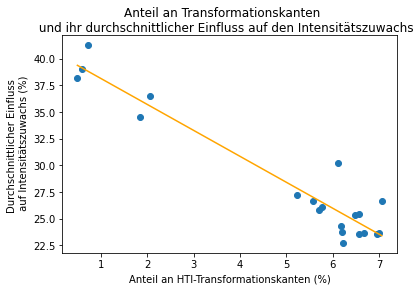

,Anzahl_HTI_Kanten,avg_combined,avg_connect
Anzahl_HTI_Kanten,1.000000,-0.868607,-0.957434
avg_combined,-0.868607,1.000000,0.884155
avg_connect,-0.957434,0.884155,1.000000


In [34]:
# Durchschnittlicher Anteil an Intensitätszuwachs durch funktionelle Gruppe


tch = model_graph.run("""
MATCH ()-[t:HAS_TRANSFORMED_INTO]->()
RETURN t.transformation_unit as funktionelle_Gruppe, 
        count(t.transformation_unit) as Anzahl_HTI_Kanten,
        avg(t.normalized_combined_weight) as avg_combined,
        avg(t.normalized_connected_weight) as avg_connect
ORDER BY Anzahl_HTI_Kanten DESC
""").to_data_frame()

tch.Anzahl_HTI_Kanten = tch.Anzahl_HTI_Kanten/tch.Anzahl_HTI_Kanten.sum()*100
tch.avg_connect = tch.avg_connect*100

#print(tch)

#tch = tch.sample(frac=1).reset_index(drop=True)
print(tch)

b, m = polyfit(tch.Anzahl_HTI_Kanten, tch.avg_connect, 1)


plt.scatter(tch.Anzahl_HTI_Kanten, tch.avg_connect)
plt.plot(tch.Anzahl_HTI_Kanten, b + m * tch.Anzahl_HTI_Kanten, '-', color='orange')
plt.xlabel('Anteil an HTI-Transformationskanten (%)')
plt.ylabel('Durchschnittlicher Einfluss \n auf Intensitätszuwachs (%)')
plt.suptitle('Anteil an Transformationskanten \n und ihr durchschnittlicher Einfluss auf den Intensitätszuwachs')

specific = 'abb_080_corr_hti'
plt.savefig(path_file + specific + '.pdf', bbox_inches='tight')

plt.show()

tch.corr()

   funktionelle_Gruppe  Anzahl_HTI_Kanten  avg_combined  avg_connect
0              -C1 -O1               7040      0.271610     0.266233
1                  -C1               6978      0.242761     0.236463
2              -C1 -H2               6941      0.242937     0.235671
3                   O1               6656      0.237454     0.236581
4                  -H2               6551      0.254149     0.253911
5              -C2 -H2               6550      0.242005     0.235329
6                H2 O1               6457      0.251595     0.253473
7           -C1 -H2 O1               6198      0.228543     0.227157
8               -H2 O1               6183      0.234978     0.237739
9          -C2 -H4 -O1               6166      0.250388     0.243295
10             -C1 -O2               6097      0.301732     0.301738
11         -C4 -H4 -O1               5757      0.267978     0.260664
12                  O2               5700      0.252588     0.258344
13             -H2 -O1            

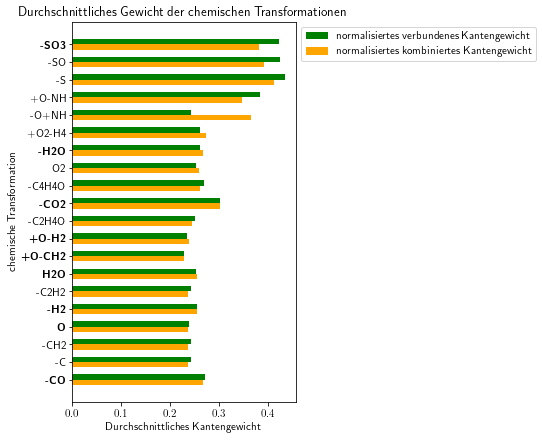

In [160]:
# durchschnittliches Gewicht der HTI-Kanten

tch = model_graph.run("""
MATCH ()-[t:HAS_TRANSFORMED_INTO]->()
RETURN t.transformation_unit as funktionelle_Gruppe, 
        count(t.transformation_unit) as Anzahl_HTI_Kanten,
        avg(t.normalized_combined_weight) as avg_combined,
        avg(t.normalized_connected_weight) as avg_connect
ORDER BY Anzahl_HTI_Kanten DESC
""").to_data_frame()

tch.avg_combined = tch.avg_combined
tch.avg_connect = tch.avg_connect

print(tch)

rc('text', usetex=True)
#font = {'family' : 'DejaVu Sans',
#        'weight' : 'normal',
#        'size'   : 12}

#plt.rc('font', **font)
#plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams.update({'font.size': 11})
#plt.rcParams.update({'font.family': "arial"})
#plt.rcParams["font.family"] = "helvetica"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
#labels = ['-C4H4O', '-H2', '-C2H2', '-C', '-CH2', 'H2O', 'O2', '+O-H2', '+O-CH2', '+O-NH', 'O', '-CO', '-C2H4O', '+O2-H4', '-CO2', '-H2O', '-O+NH', '-SO', '-S', '-SO3']
labels = [r'\textbf{-CO}', '-C', '-CH2', r'\textbf{O}', r'\textbf{-H2}', '-C2H2', r'\textbf{H2O}', r'\textbf{+O-CH2}', r'\textbf{+O-H2}', '-C2H4O', r'\textbf{-CO2}', '-C4H4O', 'O2', r'\textbf{-H2O}', '+O2-H4', '-O+NH', '+O-NH', '-S', '-SO', r'\textbf{-SO3}']
x = np.arange(len(labels))
height = 0.3
plt.figure(figsize=(4, 7))
plt.barh(x + height/2, tch.avg_combined, height = 0.3, color='green', label='CTI-Kanten')
plt.barh(x - height/2 , tch.avg_connect, height = 0.3, color='orange', label='HTI-Kanten')
plt.yticks(x, labels = labels)
plt.xticks(fontname = "sans-serif")
plt.title('Durchschnittliches Gewicht der chemischen Transformationen')
plt.ylabel('chemische Transformation')
plt.xlabel('Durchschnittliches Kantengewicht')
plt.legend(['normalisiertes verbundenes Kantengewicht', 'normalisiertes kombiniertes Kantengewicht'], bbox_to_anchor=(1, 1))

specific = 'abb_081_anteilnahme'
#plt.savefig(path_file + specific + '.pdf', bbox_inches='tight')

plt.show()

0.26942552368372646
0.295964897595723


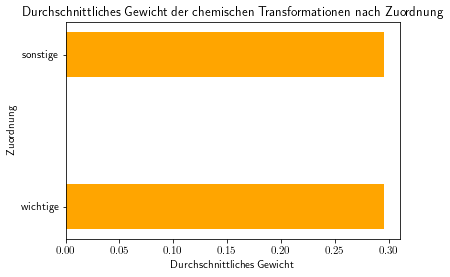

In [161]:
tch_in = model_graph.run("""
MATCH ()-[t:HAS_TRANSFORMED_INTO]->()
WHERE t.transformation_unit IN ['O1', '-C1 -O1', '-O3 -S1', '-C1 -O2', '-H2 -O1', '-H2', 'H2 O1', '-H2 O1', '-C1 -H2 O1']
RETURN t.transformation_unit as funktionelle_Gruppe, 
        count(t.transformation_unit) as Anzahl_HTI_Kanten,
        avg(t.normalized_combined_weight) as avg_combined,
        avg(t.normalized_connected_weight) as avg_connect
ORDER BY Anzahl_HTI_Kanten DESC
""").to_data_frame()

tch_nin = model_graph.run("""
MATCH ()-[t:HAS_TRANSFORMED_INTO]->()
WHERE NOT t.transformation_unit IN ['O1', '-C1 -O1', '-O3 -S1', '-C1 -O2', '-H2 -O1', '-H2', 'H2 O1', '-H2 O1', '-C1 -H2 O1']
RETURN t.transformation_unit as funktionelle_Gruppe, 
        count(t.transformation_unit) as Anzahl_HTI_Kanten,
        avg(t.normalized_combined_weight) as avg_combined,
        avg(t.normalized_connected_weight) as avg_connect
ORDER BY Anzahl_HTI_Kanten DESC
""").to_data_frame()

#tch.avg_combined = tch.avg_combined*100
#tch.avg_connect = tch.avg_connect*100
print(tch_in.avg_connect.mean())
print(tch_nin.avg_connect.mean())

labels = ['wichtige','sonstige']
x = np.arange(len(labels))
#plt.figure(figsize=(3, 2))
plt.barh(x, tch_in.avg_connect.mean(), height = 0.3, color='green')
plt.barh(x, tch_nin.avg_connect.mean(), height = 0.3, color='orange')
plt.yticks(x, labels = labels)
plt.title('Durchschnittliches Gewicht der chemischen Transformationen nach Zuordnung')
plt.ylabel('Zuordnung')
plt.xlabel('Durchschnittliches Gewicht')
plt.show()

